***The below represents the solution to the Introduction to Python - Extract, Transform, Load (ETL) case study.***

Background:

Steve Rummel, Senior Manager, Data Analytics & Digitization, created the below Python training course as part of his personal study of Python and development of training materials for business users of Python, on his own time and using his own resources prior to his employment at CVS. He granted permission to the the CVS Health Internal Audit department to adapt the case study into a more robustly documented course to help employees upskill in Python. Additional information in the commented sections has also been added by Alan Harrington, Data Scientist, for clarification and organizational purposes.

Scenario:

Your supervisor asks you to perform the following based on data they have collected as part of an audit:

1) Clean and consistently format the data;
2) Combine the data together;
3) Identify all unique customers and customer IDs;
4) Summarize the data to show how many people are in each client;
5) Identify records with a service expiration date prior to system date;
6) Show the top 5 records with customer expense greater than the client threshold;
7) Summarize the data by client name and amount where customer expenses exceed the client threshold; and
8) Graph the data by distribution of Count of Customers by Birth Year (You’ll need to use matplotlib).

Notes:

Note 1: The Python script below creates fake member data using the Faker library. Any semblance to real life individuals is purely coincidental.

Note 2: Some functions were taken and adapted from various websites, including caktusgroup.com and stackoverflow.com. Any instances where functions were created that were not authored by Steve Rummel have been cited appropriately.

Note 3: If a user is an Aetna user, reference the Aetna Nexus respository to ensure that the Python Libraries used herein are still able to be used.

Note 4: Any recommendations/feedback should be sent to Steve Rummel, steven.rummel@cvshealth.com, and Alan Harrington, harringtona@aetna.com.

Note 5: Faker specific documentation can be found at https://faker.readthedocs.io/en/master/ for additional options to customize the script below

Note 6: Pandas specific documentation can be found at https://pandas.pydata.org/.

Note 7: NumPy specific documentation can be found at https://numpy.org/.

Note 8: DateTime specific documentation can be found at https://docs.python.org/3/library/datetime.html.

Note 9: Pathlib specific documentation can be found at https://docs.python.org/3/library/pathlib.html.

Note 10: Matplotlib specific documentation can be found at https://matplotlib.org/stable/tutorials/introductory/pyplot.html.

Note 11: String specific documentation can be found at https://docs.python.org/3/library/string.html

Note 12: CSV specific documentation can be found at https://docs.python.org/3/library/csv.html

Note 13: Random specific documentation can be found at https://docs.python.org/3/library/random.html

Note 14: Users should familiarize themselves with the library documentation above.

Note 15: In the 'Output' folder, there should be 9 files output:

CLIENTS_MASTER.csv
Data_MASTER.csv
Data_MASTER.pkl
File_1.csv
File_2.csv
File_3.csv
File_4.csv
File_5.csv
SOLUTION_DATASET.csv
Note 16: Rerunning the script will just overwrite the outputs.

In [1]:
# Import the required libraries and modules.
# Note, some users may not have some of these pre-installed.
# Verify with the nexus to ensure correct version installation of libraries.

import pandas as pd
import datetime
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create a variable named 'src_dir' and set the value to the 
# current working directory path, grabbing only those files
# with a .csv extension.
src_dir = Path.cwd().joinpath('Output').glob('File_*.csv')

# Create a variable named 'customer_data' and load into it 
# a blank dataframe.
customer_data = pd.DataFrame()

# for each file within the 'src_dir' variable concatenate
# load into the 'customer_data' variable the data from each file,
# read in as a string, and encoded as 'latin1'.
# Note, there are various types of encodings, latin1 will force a user
# to deal with unclean data and different symbols within the data that would
# not be there with unicode UTF-8.
for file in src_dir:
    customer_data = pd.concat([customer_data, pd.read_csv(str(file), encoding='latin1')])

# Create a variable named 'client_master' and set the value to the 
# current worknig directory path, grabing the "CLIENTS_MASTER.csv file"
client_master = Path.cwd().joinpath('Output').joinpath('CLIENTS_MASTER.csv')

# Create a variable named 'client_data' and load into it data from the 
# 'client_master' variable, with an encoding of latin1, again forcing
# a user to deal with various types of characters.
client_data = pd.read_csv(client_master, encoding='latin1')

# Create a variable named 'all_records' and merge (which joins data)
# the 'customer_data' and the 'client_data' data together. 
# Note 1: The below is setup specifically to be joined on a specific
# left or right context and how to join the data (left).
# Note 2: Join key is case-sensitive.
all_records = pd.merge(customer_data,
                       client_data,
                       left_on='Client_ID',
                       right_on='CLIENT_ID',
                       how='left')

#==================================================================
# Print out all unique client names
print(all_records['CLIENT_NAME'].unique())

# Create a variable named 'all_records' that only locates records where
# the CLIENT_NAME is not named 'TEST_CLIENT'
all_records = all_records.loc[all_records['CLIENT_NAME']!='TEST_CLIENT']

# Do we have any test plan IDs? Should be ~1% of the population.
# Print out all unique plan IDs.
print(all_records['Plan_ID'].unique())

# Create a variable named 'all_records' that only locates records where
# the Plan_ID is not named 'TEST'
all_records = all_records.loc[all_records['Plan_ID']!='TEST']


# The below will reformat the birthdates for the various birthdate fields.
# Note: Students will have to figure out the formats used by analyzing the
# provided datasets. Below are the correct versions from the original
# data generator. Also, used a list of lists to illustrate looping with
# a list of lists as a handy reference.
birthdate_list = [['Birthdate_01', "%m/%d/%Y"],
                  ['Birthdate_02', "%m%d%y"],
                  ['Birthdate_03', "%m-%d-%Y"],
                  ['Birthdate_04', "%Y%m%d"],
                 ]
# Create a loop that for every birth_date in the birthdate_list
# format each birthdate as a string and then turn each birthdate into 
# a datetime field, using errors='coerce' to set any invalid parsing
# as NaT.
for birth_date in birthdate_list:
    all_records[birth_date[0]]=all_records[birth_date[0]].astype(str)
    all_records[birth_date[0]]=pd.to_datetime(all_records[birth_date[0]],
                                              format=(birth_date[1]),
                                              errors='coerce')
    
# Now, since we know that the birthdate fields are only populated in some files,
# we can safely assume that that is the only column with a value, and the other
# columns will be NULL, because we used 'coerce' above when populating our date values.
# Since a valid date is always treated as 'more than' a null value, taking the maximum
# value of the four date columns will yield correct results.
all_records['CORRECT_BIRTHDATE']=all_records[['Birthdate_01',
                                              'Birthdate_02',
                                              'Birthdate_03',
                                              'Birthdate_04']].max(axis=1)    

#=====================================================================================

# Summarize the master data file to show how many people are in each client.
print("=====================================================================")

# Create a variable named summary and load into it a grouped summary of the 
# all_records variable, grouped by 'CLIENT_NAME' and 'CLIENT_ID', displaying a
# count of client names.
summary = all_records.groupby(['CLIENT_NAME', 'Client_ID'])['CLIENT_NAME'].count()

# Print the below message
print("Count of Customers by Client")

#Print out the data within the 'summary' variable
print(summary)

# Identify customers whose accounts have expired as of the date of the data extract.
# Print the below messages.
print("=====================================================================")
print("Top 5 records with service expiratins dates prior to system date.")

# Print out the first 5 records (denoted by .head()) with only the 'Customer_ID',
# 'Client_ID', 'Plan_ID', 'Service_Expiration_Date', and 'SYSTEM_DATE' where the
# 'Service_Expiration_Date' comes before the 'SYSTEM_DATE'.
print(all_records[['Customer_ID',
                  'Client_ID',
                  'Plan_ID',
                  'Service_Expiration_Date',
                  'SYSTEM_DATE']].loc[all_records['Service_Expiration_Date']<all_records['SYSTEM_DATE']].head())

# Identify clients whose account balances exceed the threshold value for that client.
# Print the below messages.
print("=====================================================================")
print("Top 5 records with customer expenses greater than the client threshold.")

# Print out the first 5 records (denoted by .head()) with only the 'Customer_ID',
# 'Client_ID', 'Plan_ID', 'CUST_EXP', and 'THRESHOLD' where the
# 'CUST_EXP' is greater than the 'THRESHOLD' amount.
print(all_records[['Customer_ID',
                  'Client_ID',
                  'Plan_ID',
                  'CUST_EXP',
                  'THRESHOLD']].loc[all_records['CUST_EXP']>all_records['THRESHOLD']].head())

# Calculate the excess account balances, then summarize by client.
# Print the below message.
print("=====================================================================")
# Create a new field named 'CUSTOMER_VARIANCE' that represents the difference
# between each record's 'THRESHOLD' field and the 'CUST_EXP' field.
all_records['CUSTOMER_VARIANCE']=all_records['THRESHOLD']-all_records['CUST_EXP']

# Print the below message.
print("Summary of total $ where customer expenses exceed the client threshold.")

# Display only those instances where the data within all_records has a 
# 'CUST_EXP' amount is greater than the 'THRESHOLD' amount and group this data by
# 'CLIENT_NAME' and display the sum of the 'CUSTOMER_VARIANCE'.
all_records.loc[all_records['CUST_EXP']>all_records['THRESHOLD']].groupby(['CLIENT_NAME'])['CUSTOMER_VARIANCE'].sum()


['Acme Health Care' 'Amazing Distribution Co. Employee HC'
 'Federal Hornswogglers Union HC' 'TEST_CLIENT'
 'Statler & Waldorf Investment Group' 'Massive Dynamic Employee HC']
['F' 'B' 'A' 'C' 'D' 'TEST']
Count of Customers by Client
CLIENT_NAME                           Client_ID
Acme Health Care                      YGXIE4       28742
Amazing Distribution Co. Employee HC  O1W8C0        9920
Federal Hornswogglers Union HC        EZVEHL       18930
Massive Dynamic Employee HC           A07XQA       23718
Statler & Waldorf Investment Group    40KQW8       13844
Name: CLIENT_NAME, dtype: int64
Top 5 records with service expiratins dates prior to system date.
    Customer_ID Client_ID Plan_ID Service_Expiration_Date SYSTEM_DATE
2     SZAASI80Z    EZVEHL       B              2023-04-07  2023-07-07
95    XNSNY0547    EZVEHL       A              2023-06-22  2023-07-07
121   2JBMJW63W    O1W8C0       B              2023-06-28  2023-07-07
182   XAOUO00HN    A07XQA       F              2023-04-

CLIENT_NAME
Acme Health Care                        -93880.26
Amazing Distribution Co. Employee HC    -74220.08
Federal Hornswogglers Union HC          -51089.81
Massive Dynamic Employee HC            -162992.44
Statler & Waldorf Investment Group      -13211.58
Name: CUSTOMER_VARIANCE, dtype: float64

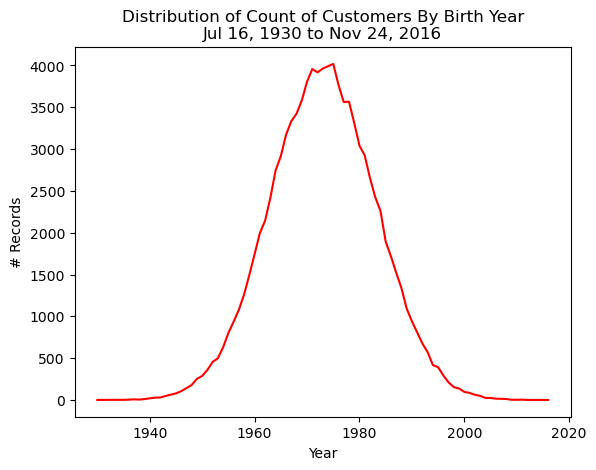

In [3]:
# Create a chart showing the distribution of count of customers by Birth Year

# Reimporting libraries as this can be run as a standalone cell.
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

# Create a list of specific fields to use 
DATE_FIELDS = ['CUSTOMER_BIRTHDAY', 'Service_Expiration_Date', 'SYSTEM_DATE']

# Create a specific date format.
DATE_FORMAT = '%Y-%m-%d'

# Create a variable named solution_master that pulls in data from the current
# working directory path, specifically the 'SOLUTION_DATASET.csv' path.
solution_master = Path.cwd().joinpath('Output').joinpath('SOLUTION_DATASET.csv')

# Create a variable named 'master' and read in the csv data from the 
# SOLUTION_DATASET.csv file, read in with latin1 encording. 
master = pd.read_csv(solution_master, encoding='latin1')

# For each date field in the DATE_FIELDS variable, format the dates using the DATE_FORMAT 
# above and coerce any errors.
for date_field in DATE_FIELDS:
    master[date_field]=pd.to_datetime(master[date_field], format=DATE_FORMAT, errors='coerce')

# Create a variable named 'maxval' which is the most recent birthdate
maxval=max(master['CUSTOMER_BIRTHDAY']).strftime('%b %d, %Y')

# Create a variable named 'minval' which is the earliest birthdate
minval=min(master['CUSTOMER_BIRTHDAY']).strftime('%b %d, %Y')

# Create a dataframe named 'by_year' which holds only the years
# for each 'CUSTOMER_BIRTHDATE' within the data.
by_year=pd.DataFrame(master['CUSTOMER_BIRTHDAY'].dt.year)

#Plot the data.
plt.plot(by_year.groupby(['CUSTOMER_BIRTHDAY']).size(), color = 'red')
plt.title('Distribution of Count of Customers By Birth Year\n{} to {}'.format(minval, maxval))
plt.xlabel('Year')
plt.ylabel('# Records')
plt.show()